In [1]:
import numpy as np
import scipy as sp
import corner
import multiprocessing

from iminuit import Minuit

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from mcmc import metropolis_hastings
from plot import plot_2d_pdf_contour

np.random.seed(7)

In [2]:
M = 125 # GeV

def gen_bkg(N):
    return sp.stats.expon(loc=100, scale=1/0.05).rvs(N)

def gen_sig(N, m=M):
    return sp.stats.norm(loc=m, scale=2).rvs(N)

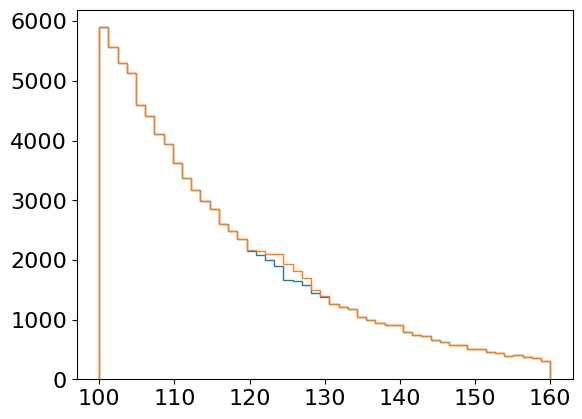

In [3]:
N_bkg = 100000
N_sig = 1000

mc_bkg = gen_bkg(N_bkg)
mc_sig = gen_sig(N_sig)

bins = np.linspace(100, 160, 50)

bkg_counts, bins = np.histogram(mc_bkg, bins=bins)
sig_counts, bins = np.histogram(mc_sig, bins=bins)

plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)


In [4]:
def nll(s, b, sig, bkg, data):
    '''
    -2*log(p(data|theta))
    '''
    return -2*np.sum(sp.stats.poisson.logpmf(data, s*sig+b*bkg))

def nlprior(m, b):
    '''
    -2*log(p(theta))
    '''
    ps = 0 if 0 <= m <= 5 else np.inf
    b_exp = 1
    sigma_b = 0.5
    pb = ((b-b_exp)/sigma_b)**2
    return ps+pb

def nlposterior(s, b, sig, bkg, data):
    '''
    -2*log(p(theta|data))
    '''
    return nll(s, b, sig, bkg, data) + nlprior(s, b)

In [5]:
data_bkg = gen_bkg(N_bkg)
data_sig = gen_sig(N_sig)

data_bkg_counts, bins = np.histogram(data_bkg, bins=bins)
data_sig_counts, bins = np.histogram(data_sig, bins=bins)

data_counts = data_bkg_counts+2*data_sig_counts

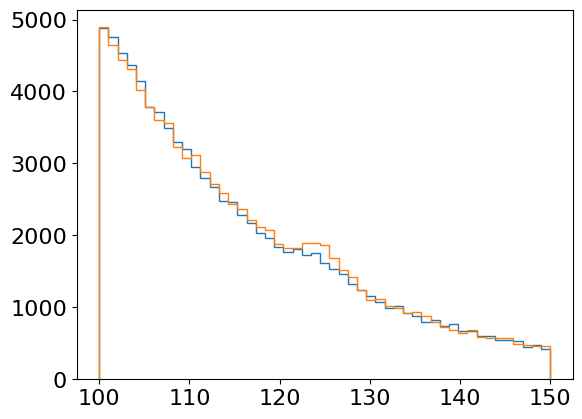

In [6]:
plt.stairs(sig_counts+bkg_counts, bins)
plt.stairs(data_counts, bins)

In [7]:
nll_unconstr = lambda s, b: nll(s, b, sig_counts, bkg_counts, data_counts)

m = Minuit(nll_unconstr, 1,1, name=(r'$s$', r'$b$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 552.9                      │              Nfcn = 47               │
│ EDM = 4.5e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $s$  │   1.94    │   0.12    │            │            │         │         │       │
│ 1 │ $b$  │  1.0008   │  0.0035   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────┐
│     │       $s$       $b$ │
├─────┼─────────────────────┤
│ $s$ │    0.0135 -0.125e-3 │
│ $b$ │ -0.125e-3  1.23e-05 │
└─────┴─────────────────────┘

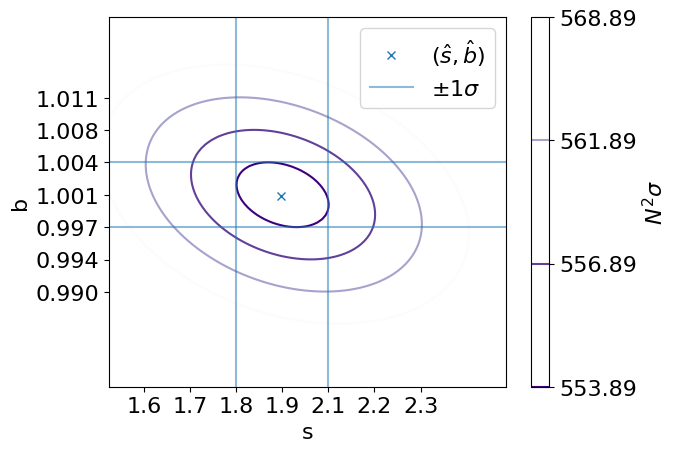

In [8]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_unconstr,
    x_range=(1.5, 2.5),
    y_range=(0.98, 1.02),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label='s',
    y_label='b',
    mode_label=r'$(\hat s, \hat b)$',
    file='plots/ex_nll_constr.pdf'
    )

In [9]:
nll_constr = lambda s, b: nlposterior(s, b, sig_counts, bkg_counts, data_counts)

m = Minuit(nll_constr, 1,1, name=(r'$s$', r'$b$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 552.9                      │              Nfcn = 47               │
│ EDM = 4.5e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $s$  │   1.94    │   0.12    │            │            │         │         │       │
│ 1 │ $b$  │  1.0008   │  0.0035   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────┐
│     │       $s$       $b$ │
├─────┼─────────────────────┤
│ $s$ │    0.0135 -0.125e-3 │
│ $b$ │ -0.125e-3  1.23e-05 │
└─────┴─────────────────────┘

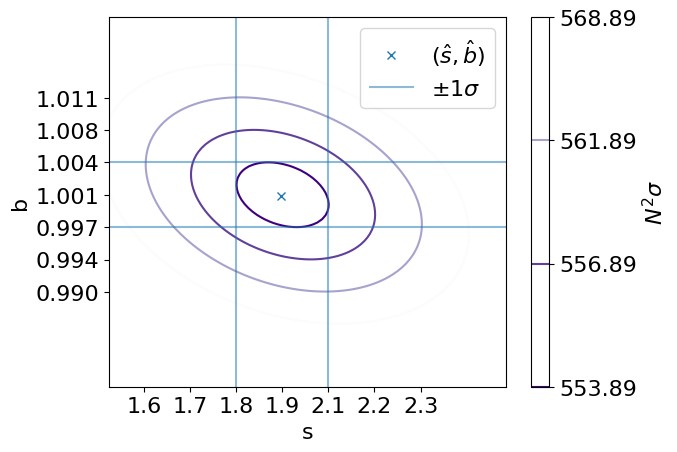

In [10]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_constr,
    x_range=(1.5, 2.5),
    y_range=(0.98, 1.02),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label='s',
    y_label='b',
    mode_label=r'$(\hat s, \hat b)$',
    file='plots/ex_nll_constr.pdf'
    )

In [11]:
iterations = 500000
chains = 8

nlpost = lambda pars: nlposterior(*pars, sig_counts, bkg_counts, data_counts)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 3), np.random.uniform(0, 3)] for _ in range(chains)
]

def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point)
    return chain

with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

all_samples = np.vstack(chains)

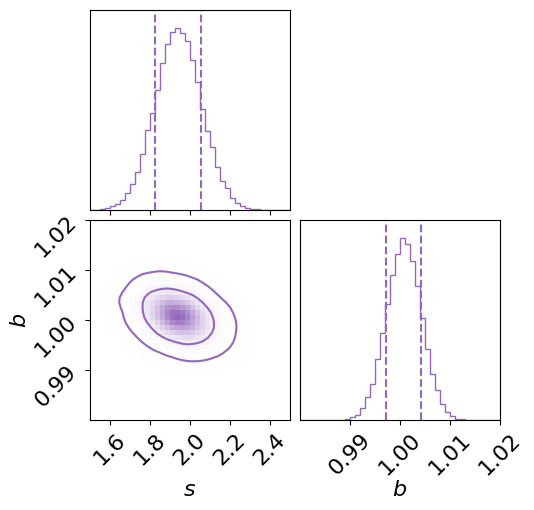

In [12]:
fig = corner.corner(
    all_samples,
    bins=40,
    range=[(1.5,2.5), (0.98,1.02)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$s$', r'$b$'],
    color='tab:purple',
    );

file='plots/ex_posterior.pdf'
fig.savefig(file)

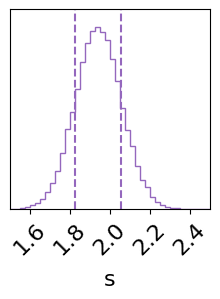

In [13]:
fig = corner.corner(
    all_samples[:,0],
    bins=40,
    range=[(1.5,2.5)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r's'],
    color='tab:purple',
    );

file='plots/ex_marginal_posterior.pdf'
fig.savefig(file)

In [14]:
np.mean(all_samples[:,0]), np.std(all_samples[:,0])

(np.float64(1.9405594888250826), np.float64(0.11696191655555727))

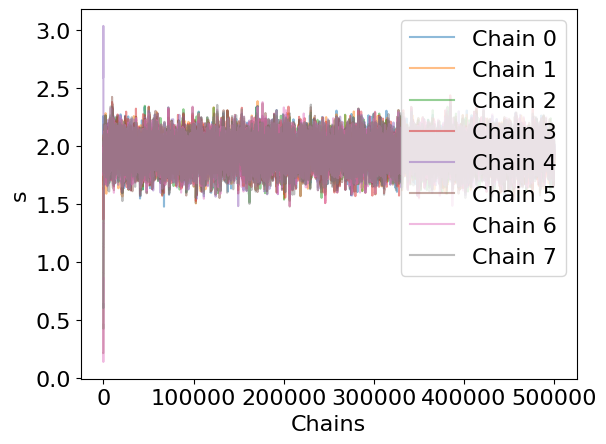

In [15]:
for i,c in enumerate(chains):
    plt.plot(c[:,0], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel('s')
plt.legend(loc='upper right')

file='plots/ex_trace_s.pdf'
plt.savefig(file, bbox_inches='tight')

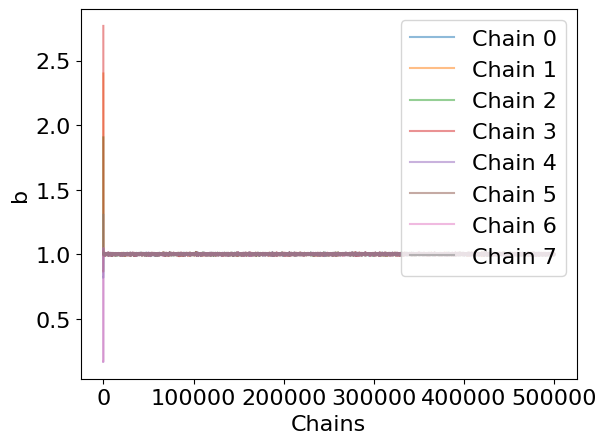

In [16]:
for i,c in enumerate(chains):
    plt.plot(c[:,1], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel('b')
plt.legend(loc='upper right')

file='plots/ex_trace_b.pdf'
plt.savefig(file, bbox_inches='tight')